In [4]:
%matplotlib inline
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
print('All modules imported.')

All modules imported.


In [5]:
import tensorflow as tf

## Dataset

In [6]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', 'notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', 'notMNIST_test.zip')

# Make sure the files aren't corrupted
assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

All files downloaded.


In [7]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Load image data as 1 dimensional array
                    # We're using float32 to save on memory space
                    feature = np.array(image, dtype=np.float32).flatten()

                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Get the features and labels from the zip files
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

# Limit the amount of data to work with a docker container
docker_size_limit = 150000 #500,000 training images
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

100%|███████████████████████████████████████| 10001/10001 [00:03<00:00, 3222.81files/s]


All features and labels uncompressed.


### Explore the data

train_features (150000, 784)
Training Image (784,)
train_labels (150000,)
Label:  B


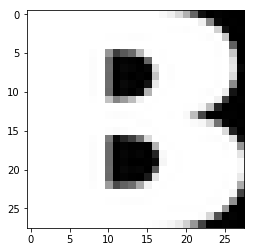

In [8]:
print("train_features", train_features.shape)
print("Training Image", train_features[0].shape)
print("train_labels", train_labels.shape)
print("Label: ", train_labels[0])
plt.imshow(np.array(train_features[0].reshape((28,28))),cmap='Greys_r')
plt.show()

## Groom the Data

Normalize the data

In [ ]:
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    Xmin = np.min(image_data) #0
    Xmax = np.max(image_data) #255
    a = 0.1
    b = 0.9
    #print("Xmin:", Xmin, "Xmax:", Xmax)
    return a + (((image_data-Xmin)*(b-a))/(Xmax- Xmin))

if not is_features_normal:
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True

One Hot Encode Labels

In [ ]:
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)
    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True


In [ ]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Save the Data

In [ ]:
# Save the data for easy access
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

## Create Checkpoint

In [ ]:
# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

In [ ]:
print("Dataset Stats")
print("train_features: ", train_features.shape)
print("valid_features: ", valid_features.shape)
print("test_features: ", test_features.shape)

## Parameters

In [11]:
# Parameters
learning_rate = 0.00001
epochs = 10
batch_size = 128

# Number of samples to calculate validation and accuracy
# Decrease this if you're running out of memory to calculate accuracy
test_valid_size = 256

# Network Parameters
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.75  # Dropout, probability to keep units

## Weights and Biases

In [12]:
# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    'out': tf.Variable(tf.random_normal([1024, n_classes]))}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))}

## Layers

In [13]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)
def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')


## Network

In [14]:
def conv_net(x, weights, biases, dropout):
    # Layer 1 - 28*28*1 to 14*14*32
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    # Layer 2 - 14*14*32 to 7*7*64
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer - 7*7*64 to 1024
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output Layer - class prediction - 1024 to 10
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

## Run Session

In [15]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, 28, 28, 1])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# Model
logits = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(\
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)\
    .minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf. global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(epochs):
        for batch in range(mnist.train.num_examples//batch_size):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            sess.run(optimizer, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: dropout})

            # Calculate batch loss and accuracy
            loss = sess.run(cost, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: 1.})
            valid_acc = sess.run(accuracy, feed_dict={
                x: mnist.validation.images[:test_valid_size],
                y: mnist.validation.labels[:test_valid_size],
                keep_prob: 1.})

            print('Epoch {:>2}, Batch {:>3} -'
                  'Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                epoch + 1,
                batch + 1,
                loss,
                valid_acc))

    # Calculate Test Accuracy
    test_acc = sess.run(accuracy, feed_dict={
        x: mnist.test.images[:test_valid_size],
        y: mnist.test.labels[:test_valid_size],
        keep_prob: 1.})
    print('Testing Accuracy: {}'.format(test_acc))

Epoch  1, Batch   1 -Loss: 64258.9570 Validation Accuracy: 0.085938
Epoch  1, Batch   2 -Loss: 51398.9727 Validation Accuracy: 0.101562
Epoch  1, Batch   3 -Loss: 44075.4062 Validation Accuracy: 0.101562
Epoch  1, Batch   4 -Loss: 38978.5117 Validation Accuracy: 0.101562
Epoch  1, Batch   5 -Loss: 28400.0605 Validation Accuracy: 0.097656
Epoch  1, Batch   6 -Loss: 24293.8535 Validation Accuracy: 0.136719
Epoch  1, Batch   7 -Loss: 25216.8750 Validation Accuracy: 0.144531
Epoch  1, Batch   8 -Loss: 23023.1562 Validation Accuracy: 0.125000
Epoch  1, Batch   9 -Loss: 16957.4980 Validation Accuracy: 0.144531
Epoch  1, Batch  10 -Loss: 20262.4805 Validation Accuracy: 0.152344
Epoch  1, Batch  11 -Loss: 21633.7500 Validation Accuracy: 0.179688
Epoch  1, Batch  12 -Loss: 18296.3145 Validation Accuracy: 0.187500
Epoch  1, Batch  13 -Loss: 15902.8018 Validation Accuracy: 0.195312
Epoch  1, Batch  14 -Loss: 17379.4219 Validation Accuracy: 0.203125
Epoch  1, Batch  15 -Loss: 17678.4121 Validation

Epoch  1, Batch 121 -Loss:  4427.2637 Validation Accuracy: 0.531250
Epoch  1, Batch 122 -Loss:  4866.3457 Validation Accuracy: 0.539062
Epoch  1, Batch 123 -Loss:  4664.1338 Validation Accuracy: 0.539062
Epoch  1, Batch 124 -Loss:  3936.7139 Validation Accuracy: 0.542969
Epoch  1, Batch 125 -Loss:  3508.3120 Validation Accuracy: 0.539062
Epoch  1, Batch 126 -Loss:  4748.4810 Validation Accuracy: 0.546875
Epoch  1, Batch 127 -Loss:  4706.6367 Validation Accuracy: 0.550781
Epoch  1, Batch 128 -Loss:  5295.4375 Validation Accuracy: 0.531250
Epoch  1, Batch 129 -Loss:  4703.8086 Validation Accuracy: 0.539062
Epoch  1, Batch 130 -Loss:  4106.0088 Validation Accuracy: 0.546875
Epoch  1, Batch 131 -Loss:  4861.0015 Validation Accuracy: 0.546875
Epoch  1, Batch 132 -Loss:  4479.1138 Validation Accuracy: 0.542969
Epoch  1, Batch 133 -Loss:  4771.9673 Validation Accuracy: 0.550781
Epoch  1, Batch 134 -Loss:  3687.7017 Validation Accuracy: 0.546875
Epoch  1, Batch 135 -Loss:  5715.6021 Validation

Epoch  1, Batch 241 -Loss:  2659.5190 Validation Accuracy: 0.617188
Epoch  1, Batch 242 -Loss:  3379.1440 Validation Accuracy: 0.621094
Epoch  1, Batch 243 -Loss:  2123.9038 Validation Accuracy: 0.613281
Epoch  1, Batch 244 -Loss:  2597.9814 Validation Accuracy: 0.625000
Epoch  1, Batch 245 -Loss:  2124.0442 Validation Accuracy: 0.617188
Epoch  1, Batch 246 -Loss:  2475.9719 Validation Accuracy: 0.617188
Epoch  1, Batch 247 -Loss:  1913.5365 Validation Accuracy: 0.613281
Epoch  1, Batch 248 -Loss:  2723.7341 Validation Accuracy: 0.617188
Epoch  1, Batch 249 -Loss:  2387.4260 Validation Accuracy: 0.613281
Epoch  1, Batch 250 -Loss:  2698.3276 Validation Accuracy: 0.621094
Epoch  1, Batch 251 -Loss:  2547.8794 Validation Accuracy: 0.617188
Epoch  1, Batch 252 -Loss:  2333.2891 Validation Accuracy: 0.621094
Epoch  1, Batch 253 -Loss:  2263.9622 Validation Accuracy: 0.625000
Epoch  1, Batch 254 -Loss:  2537.5671 Validation Accuracy: 0.632812
Epoch  1, Batch 255 -Loss:  2279.8071 Validation

Epoch  1, Batch 361 -Loss:  1660.4822 Validation Accuracy: 0.656250
Epoch  1, Batch 362 -Loss:  1554.2012 Validation Accuracy: 0.656250
Epoch  1, Batch 363 -Loss:  1912.5837 Validation Accuracy: 0.656250
Epoch  1, Batch 364 -Loss:  1595.9197 Validation Accuracy: 0.652344
Epoch  1, Batch 365 -Loss:  2575.8599 Validation Accuracy: 0.656250
Epoch  1, Batch 366 -Loss:  2062.4253 Validation Accuracy: 0.656250
Epoch  1, Batch 367 -Loss:  1995.1512 Validation Accuracy: 0.660156
Epoch  1, Batch 368 -Loss:  1623.2314 Validation Accuracy: 0.660156
Epoch  1, Batch 369 -Loss:  1966.7991 Validation Accuracy: 0.660156
Epoch  1, Batch 370 -Loss:  2340.6909 Validation Accuracy: 0.656250
Epoch  1, Batch 371 -Loss:  1860.9894 Validation Accuracy: 0.660156
Epoch  1, Batch 372 -Loss:  1748.0913 Validation Accuracy: 0.660156
Epoch  1, Batch 373 -Loss:  1688.3059 Validation Accuracy: 0.656250
Epoch  1, Batch 374 -Loss:  1900.0217 Validation Accuracy: 0.660156
Epoch  1, Batch 375 -Loss:  1151.8041 Validation

Epoch  2, Batch  52 -Loss:  1440.1780 Validation Accuracy: 0.695312
Epoch  2, Batch  53 -Loss:  1788.6819 Validation Accuracy: 0.695312
Epoch  2, Batch  54 -Loss:  1268.6263 Validation Accuracy: 0.691406
Epoch  2, Batch  55 -Loss:  1217.5477 Validation Accuracy: 0.699219
Epoch  2, Batch  56 -Loss:  1589.1284 Validation Accuracy: 0.699219
Epoch  2, Batch  57 -Loss:  1431.1069 Validation Accuracy: 0.699219
Epoch  2, Batch  58 -Loss:  1556.3353 Validation Accuracy: 0.699219
Epoch  2, Batch  59 -Loss:  1524.0719 Validation Accuracy: 0.699219
Epoch  2, Batch  60 -Loss:  1535.4066 Validation Accuracy: 0.699219
Epoch  2, Batch  61 -Loss:  1605.9387 Validation Accuracy: 0.703125
Epoch  2, Batch  62 -Loss:  1349.9794 Validation Accuracy: 0.703125
Epoch  2, Batch  63 -Loss:  1546.4580 Validation Accuracy: 0.703125
Epoch  2, Batch  64 -Loss:  1471.6180 Validation Accuracy: 0.699219
Epoch  2, Batch  65 -Loss:  1051.4561 Validation Accuracy: 0.699219
Epoch  2, Batch  66 -Loss:  1480.2983 Validation

Epoch  2, Batch 172 -Loss:  1018.7261 Validation Accuracy: 0.730469
Epoch  2, Batch 173 -Loss:  1211.0481 Validation Accuracy: 0.718750
Epoch  2, Batch 174 -Loss:  1398.0199 Validation Accuracy: 0.730469
Epoch  2, Batch 175 -Loss:   873.7899 Validation Accuracy: 0.738281
Epoch  2, Batch 176 -Loss:  1178.8821 Validation Accuracy: 0.734375
Epoch  2, Batch 177 -Loss:   848.8541 Validation Accuracy: 0.738281
Epoch  2, Batch 178 -Loss:  1270.1240 Validation Accuracy: 0.738281
Epoch  2, Batch 179 -Loss:  1162.3120 Validation Accuracy: 0.734375
Epoch  2, Batch 180 -Loss:  1329.0664 Validation Accuracy: 0.738281
Epoch  2, Batch 181 -Loss:   781.3706 Validation Accuracy: 0.738281
Epoch  2, Batch 182 -Loss:   953.5500 Validation Accuracy: 0.738281
Epoch  2, Batch 183 -Loss:  1210.9108 Validation Accuracy: 0.742188
Epoch  2, Batch 184 -Loss:   997.6331 Validation Accuracy: 0.738281
Epoch  2, Batch 185 -Loss:  1266.0063 Validation Accuracy: 0.742188
Epoch  2, Batch 186 -Loss:  1056.1874 Validation

Epoch  2, Batch 292 -Loss:   876.8788 Validation Accuracy: 0.742188
Epoch  2, Batch 293 -Loss:  1274.2283 Validation Accuracy: 0.738281
Epoch  2, Batch 294 -Loss:   870.7592 Validation Accuracy: 0.750000
Epoch  2, Batch 295 -Loss:   899.9937 Validation Accuracy: 0.746094
Epoch  2, Batch 296 -Loss:  1187.4712 Validation Accuracy: 0.734375
Epoch  2, Batch 297 -Loss:  1020.0690 Validation Accuracy: 0.742188
Epoch  2, Batch 298 -Loss:  1238.0549 Validation Accuracy: 0.742188
Epoch  2, Batch 299 -Loss:  1419.8859 Validation Accuracy: 0.746094
Epoch  2, Batch 300 -Loss:   986.7589 Validation Accuracy: 0.746094
Epoch  2, Batch 301 -Loss:  1039.2891 Validation Accuracy: 0.746094
Epoch  2, Batch 302 -Loss:  1405.8390 Validation Accuracy: 0.746094
Epoch  2, Batch 303 -Loss:   916.4078 Validation Accuracy: 0.746094
Epoch  2, Batch 304 -Loss:   711.5842 Validation Accuracy: 0.750000
Epoch  2, Batch 305 -Loss:   913.0569 Validation Accuracy: 0.750000
Epoch  2, Batch 306 -Loss:   707.6837 Validation

Epoch  2, Batch 412 -Loss:   851.0692 Validation Accuracy: 0.753906
Epoch  2, Batch 413 -Loss:   930.7715 Validation Accuracy: 0.757812
Epoch  2, Batch 414 -Loss:   880.6614 Validation Accuracy: 0.757812
Epoch  2, Batch 415 -Loss:  1121.4854 Validation Accuracy: 0.761719
Epoch  2, Batch 416 -Loss:   979.8308 Validation Accuracy: 0.761719
Epoch  2, Batch 417 -Loss:   823.8632 Validation Accuracy: 0.761719
Epoch  2, Batch 418 -Loss:  1219.6870 Validation Accuracy: 0.765625
Epoch  2, Batch 419 -Loss:   841.4670 Validation Accuracy: 0.761719
Epoch  2, Batch 420 -Loss:   882.7383 Validation Accuracy: 0.765625
Epoch  2, Batch 421 -Loss:   584.5535 Validation Accuracy: 0.761719
Epoch  2, Batch 422 -Loss:   580.5248 Validation Accuracy: 0.765625
Epoch  2, Batch 423 -Loss:   777.5316 Validation Accuracy: 0.769531
Epoch  2, Batch 424 -Loss:   874.0952 Validation Accuracy: 0.765625
Epoch  2, Batch 425 -Loss:   865.2236 Validation Accuracy: 0.761719
Epoch  2, Batch 426 -Loss:  1076.5538 Validation

Epoch  3, Batch 103 -Loss:   610.6558 Validation Accuracy: 0.789062
Epoch  3, Batch 104 -Loss:   587.7841 Validation Accuracy: 0.785156
Epoch  3, Batch 105 -Loss:   816.5408 Validation Accuracy: 0.789062
Epoch  3, Batch 106 -Loss:  1046.8079 Validation Accuracy: 0.777344
Epoch  3, Batch 107 -Loss:  1083.0857 Validation Accuracy: 0.781250
Epoch  3, Batch 108 -Loss:   636.7065 Validation Accuracy: 0.781250
Epoch  3, Batch 109 -Loss:   796.2322 Validation Accuracy: 0.781250
Epoch  3, Batch 110 -Loss:   814.1167 Validation Accuracy: 0.789062
Epoch  3, Batch 111 -Loss:   939.5027 Validation Accuracy: 0.785156
Epoch  3, Batch 112 -Loss:   785.9685 Validation Accuracy: 0.789062
Epoch  3, Batch 113 -Loss:   839.5512 Validation Accuracy: 0.785156
Epoch  3, Batch 114 -Loss:   461.3395 Validation Accuracy: 0.781250
Epoch  3, Batch 115 -Loss:   863.3888 Validation Accuracy: 0.785156
Epoch  3, Batch 116 -Loss:   945.4983 Validation Accuracy: 0.785156
Epoch  3, Batch 117 -Loss:   928.5607 Validation

KeyboardInterrupt: 